In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [3]:
from keras.layers import Dropout

In [2]:
# 무비렌즈 데이터 세트 호출
data_path = './ml-latest-small/'
df = pd.read_csv(data_path+'ratings.csv')

In [5]:
# binary implicit feedback
# rating >= 3.0일 경우 positive로 간주
df['rating'] = df['rating'].apply(lambda x: 1 if x >= 3.0 else 0)

# 전체 유저 수와 영화 수
n_users = df.userId.nunique()
n_movies = df.movieId.nunique()

# 데이터를 train/valid로 나눔
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# 유저 아이디 indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}

# 영화 아이디 indexing
unique_movie_ids = df["movieId"].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# 인덱싱 된 딕셔너리를 사용하여 ID 맵핑
train["userId"] = train["userId"].map(userId_dict)
train["movieId"] = train["movieId"].map(movieId_dict)

validation["userId"] = validation["userId"].map(userId_dict)
validation["movieId"] = validation["movieId"].map(movieId_dict)

# 전체 유니크 유저 수
num_unique_users = df['userId'].nunique() + 1
# 전체 유니크 영화 수
num_unique_movies = df['movieId'].nunique() + 1

In [6]:
auc = tf.keras.metrics.AUC()

In [ ]:
# drop rate마다 loss 저장
loss_df = pd.DataFrame()

# MLP 생성하는 함수 -> dropout rate 지정
def create_mlp(hidden_layers, output, dropout_rate):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
            hidden = Dropout(dropout_rate)(hidden)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
            hidden = Dropout(dropout_rate)(hidden)
    output = Dense(1, activation='sigmoid')(hidden)
    return output

# 다양한 drop out rate를 검토
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

for rate in dropout_rates:

    # 유저/아이템 입력 레이어
    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))

    # 임베딩 차원
    n_latent_factors = 20

    # 임베딩 레이어 정의
    user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
    movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

    # 임베딩 flatten
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)

    # 유저 및 영화 임베딩 벡터 컨캣
    concat = Concatenate()([user_vector, movie_vector])

    output = create_mlp([64, 64], concat, rate)

    # 최종 모델
    model = Model(inputs=[user_input, movie_input], outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

    # 모델 학습
    history = model.fit([train.userId, train.movieId], train.rating, epochs=10, verbose=2, validation_data=([validation.userId, validation.movieId], validation.rating))

    # DF에 로스 값 기록
    loss_df[f'dropout_rate_{rate}_train'] = history.history['loss']
    loss_df[f'dropout_rate_{rate}_val'] = history.history['val_loss']

    del model


Epoch 1/10


2025-04-09 21:26:30.071628: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-04-09 21:26:30.497905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:27:01.958986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 37s - loss: 0.4091 - accuracy: 0.8258 - auc_1: 0.7679 - val_loss: 0.3903 - val_accuracy: 0.8313 - val_auc_1: 0.7995 - 37s/epoch - 15ms/step
Epoch 2/10
2521/2521 - 31s - loss: 0.3520 - accuracy: 0.8490 - auc_1: 0.8424 - val_loss: 0.3912 - val_accuracy: 0.8321 - val_auc_1: 0.8004 - 31s/epoch - 12ms/step
Epoch 3/10
2521/2521 - 30s - loss: 0.3232 - accuracy: 0.8628 - auc_1: 0.8698 - val_loss: 0.4040 - val_accuracy: 0.8292 - val_auc_1: 0.7928 - 30s/epoch - 12ms/step
Epoch 4/10
2521/2521 - 31s - loss: 0.2984 - accuracy: 0.8737 - auc_1: 0.8905 - val_loss: 0.4176 - val_accuracy: 0.8286 - val_auc_1: 0.7834 - 31s/epoch - 12ms/step
Epoch 5/10
2521/2521 - 30s - loss: 0.2785 - accuracy: 0.8823 - auc_1: 0.9057 - val_loss: 0.4418 - val_accuracy: 0.8235 - val_auc_1: 0.7774 - 30s/epoch - 12ms/step
Epoch 6/10
2521/2521 - 30s - loss: 0.2602 - accuracy: 0.8906 - auc_1: 0.9181 - val_loss: 0.4596 - val_accuracy: 0.8222 - val_auc_1: 0.7781 - 30s/epoch - 12ms/step
Epoch 7/10
2521/2521 - 30s - loss

2025-04-09 21:31:38.966101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:32:06.225675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 32s - loss: 0.4102 - accuracy: 0.8250 - auc_1: 0.7540 - val_loss: 0.3934 - val_accuracy: 0.8309 - val_auc_1: 0.7963 - 32s/epoch - 13ms/step
Epoch 2/10
2521/2521 - 30s - loss: 0.3537 - accuracy: 0.8486 - auc_1: 0.8413 - val_loss: 0.3955 - val_accuracy: 0.8316 - val_auc_1: 0.7973 - 30s/epoch - 12ms/step
Epoch 3/10
2521/2521 - 30s - loss: 0.3263 - accuracy: 0.8631 - auc_1: 0.8665 - val_loss: 0.4059 - val_accuracy: 0.8290 - val_auc_1: 0.7923 - 30s/epoch - 12ms/step
Epoch 4/10
2521/2521 - 31s - loss: 0.3060 - accuracy: 0.8713 - auc_1: 0.8840 - val_loss: 0.4204 - val_accuracy: 0.8298 - val_auc_1: 0.7922 - 31s/epoch - 12ms/step
Epoch 5/10
2521/2521 - 30s - loss: 0.2883 - accuracy: 0.8779 - auc_1: 0.8982 - val_loss: 0.4243 - val_accuracy: 0.8273 - val_auc_1: 0.7847 - 30s/epoch - 12ms/step
Epoch 6/10
2521/2521 - 29s - loss: 0.2720 - accuracy: 0.8843 - auc_1: 0.9104 - val_loss: 0.4394 - val_accuracy: 0.8222 - val_auc_1: 0.7758 - 29s/epoch - 12ms/step
Epoch 7/10
2521/2521 - 31s - loss

2025-04-09 21:36:41.524257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:37:08.648976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 32s - loss: 0.4113 - accuracy: 0.8244 - auc_1: 0.7562 - val_loss: 0.3957 - val_accuracy: 0.8295 - val_auc_1: 0.7965 - 32s/epoch - 13ms/step
Epoch 2/10
2521/2521 - 30s - loss: 0.3543 - accuracy: 0.8492 - auc_1: 0.8408 - val_loss: 0.3944 - val_accuracy: 0.8297 - val_auc_1: 0.7975 - 30s/epoch - 12ms/step
Epoch 3/10
2521/2521 - 30s - loss: 0.3283 - accuracy: 0.8614 - auc_1: 0.8649 - val_loss: 0.4030 - val_accuracy: 0.8293 - val_auc_1: 0.7976 - 30s/epoch - 12ms/step
Epoch 4/10
2521/2521 - 30s - loss: 0.3090 - accuracy: 0.8703 - auc_1: 0.8816 - val_loss: 0.4082 - val_accuracy: 0.8292 - val_auc_1: 0.7906 - 30s/epoch - 12ms/step
Epoch 5/10
2521/2521 - 31s - loss: 0.2936 - accuracy: 0.8753 - auc_1: 0.8944 - val_loss: 0.4257 - val_accuracy: 0.8235 - val_auc_1: 0.7870 - 31s/epoch - 12ms/step
Epoch 6/10
2521/2521 - 32s - loss: 0.2786 - accuracy: 0.8813 - auc_1: 0.9060 - val_loss: 0.4347 - val_accuracy: 0.8234 - val_auc_1: 0.7832 - 32s/epoch - 13ms/step
Epoch 7/10
2521/2521 - 30s - loss

2025-04-09 21:41:47.840439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:42:17.434854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 34s - loss: 0.4128 - accuracy: 0.8242 - auc_1: 0.7583 - val_loss: 0.3945 - val_accuracy: 0.8303 - val_auc_1: 0.7986 - 34s/epoch - 14ms/step
Epoch 2/10
2521/2521 - 31s - loss: 0.3555 - accuracy: 0.8477 - auc_1: 0.8397 - val_loss: 0.3956 - val_accuracy: 0.8307 - val_auc_1: 0.7974 - 31s/epoch - 12ms/step
Epoch 3/10
2521/2521 - 31s - loss: 0.3315 - accuracy: 0.8590 - auc_1: 0.8624 - val_loss: 0.3982 - val_accuracy: 0.8301 - val_auc_1: 0.7938 - 31s/epoch - 12ms/step
Epoch 4/10
2521/2521 - 32s - loss: 0.3139 - accuracy: 0.8678 - auc_1: 0.8774 - val_loss: 0.4132 - val_accuracy: 0.8271 - val_auc_1: 0.7867 - 32s/epoch - 13ms/step
Epoch 5/10
2521/2521 - 31s - loss: 0.2980 - accuracy: 0.8744 - auc_1: 0.8905 - val_loss: 0.4199 - val_accuracy: 0.8292 - val_auc_1: 0.7874 - 31s/epoch - 12ms/step
Epoch 6/10
2521/2521 - 34s - loss: 0.2829 - accuracy: 0.8812 - auc_1: 0.9024 - val_loss: 0.4369 - val_accuracy: 0.8206 - val_auc_1: 0.7769 - 34s/epoch - 14ms/step
Epoch 7/10
2521/2521 - 32s - loss

2025-04-09 21:47:05.519924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-04-09 21:47:32.501097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2521/2521 - 31s - loss: 0.4148 - accuracy: 0.8239 - auc_1: 0.7567 - val_loss: 0.3929 - val_accuracy: 0.8304 - val_auc_1: 0.7970 - 31s/epoch - 12ms/step
Epoch 2/10
2521/2521 - 30s - loss: 0.3576 - accuracy: 0.8464 - auc_1: 0.8378 - val_loss: 0.3928 - val_accuracy: 0.8310 - val_auc_1: 0.7976 - 30s/epoch - 12ms/step
Epoch 3/10
2521/2521 - 29s - loss: 0.3345 - accuracy: 0.8579 - auc_1: 0.8592 - val_loss: 0.4025 - val_accuracy: 0.8306 - val_auc_1: 0.7904 - 29s/epoch - 12ms/step
Epoch 4/10
2521/2521 - 30s - loss: 0.3171 - accuracy: 0.8656 - auc_1: 0.8742 - val_loss: 0.4071 - val_accuracy: 0.8285 - val_auc_1: 0.7902 - 30s/epoch - 12ms/step
Epoch 5/10
2521/2521 - 30s - loss: 0.3029 - accuracy: 0.8704 - auc_1: 0.8867 - val_loss: 0.4173 - val_accuracy: 0.8288 - val_auc_1: 0.7855 - 30s/epoch - 12ms/step
Epoch 6/10
2521/2521 - 30s - loss: 0.2885 - accuracy: 0.8789 - auc_1: 0.8987 - val_loss: 0.4246 - val_accuracy: 0.8208 - val_auc_1: 0.7788 - 30s/epoch - 12ms/step
Epoch 7/10
2521/2521 - 30s - loss

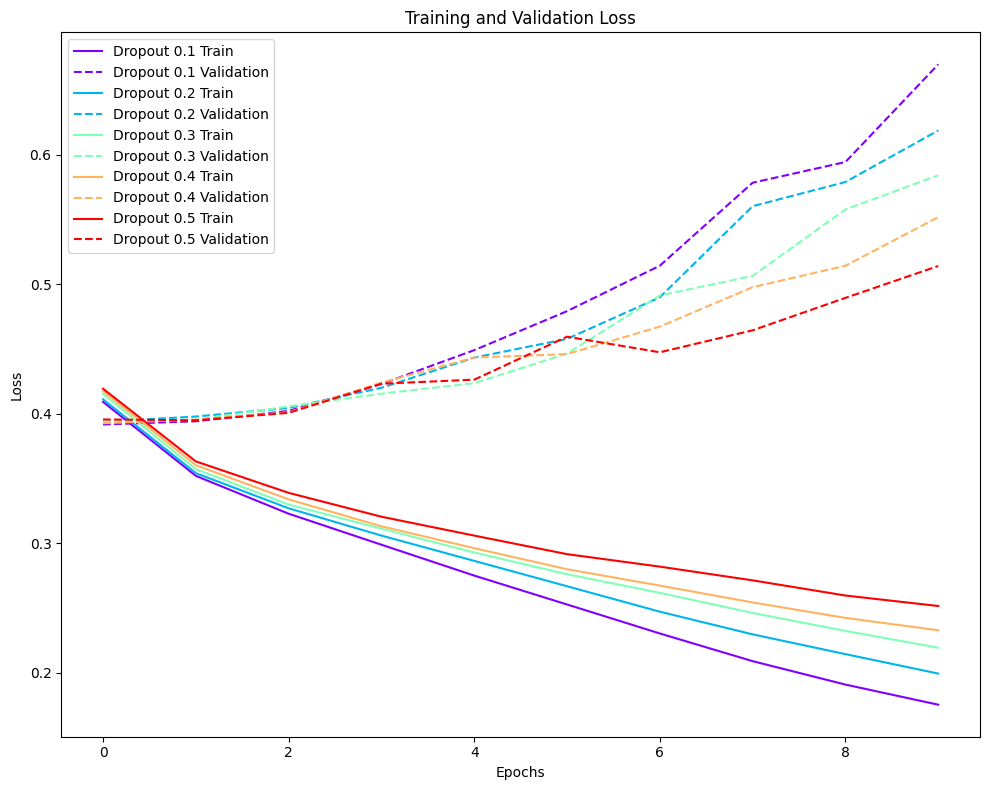

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Create a colormap
colors = cm.rainbow(np.linspace(0, 1, len(dropout_rates)))

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))

for rate, color in zip(dropout_rates, colors):
    ax.plot(loss_df[f'dropout_rate_{rate}_train'], label=f'Dropout {rate} Train', linestyle='-', color=color)
    ax.plot(loss_df[f'dropout_rate_{rate}_val'], label=f'Dropout {rate} Validation', linestyle='--', color=color)

ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

plt.tight_layout()
plt.show()


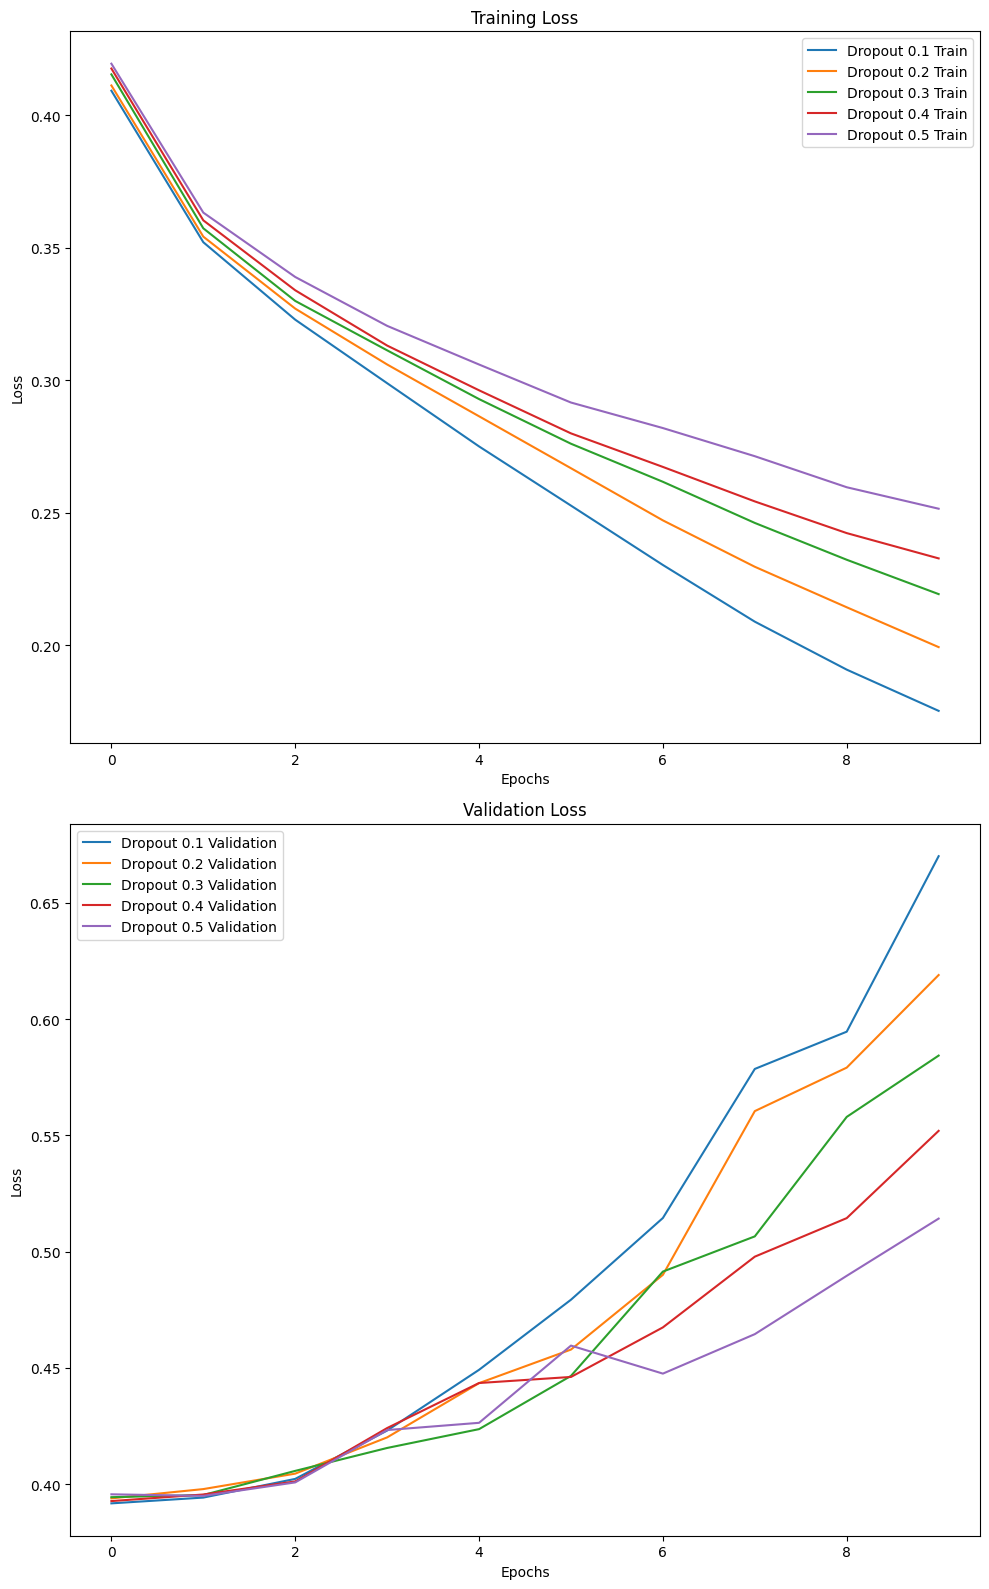

In [ ]:
import matplotlib.pyplot as plt
# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16))

for rate in dropout_rates:
    ax1.plot(loss_df[f'dropout_rate_{rate}_train'], label=f'Dropout {rate} Train')
    ax2.plot(loss_df[f'dropout_rate_{rate}_val'], label=f'Dropout {rate} Validation')

ax1.set_title('Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()
